# Least Squares and bitcoin price

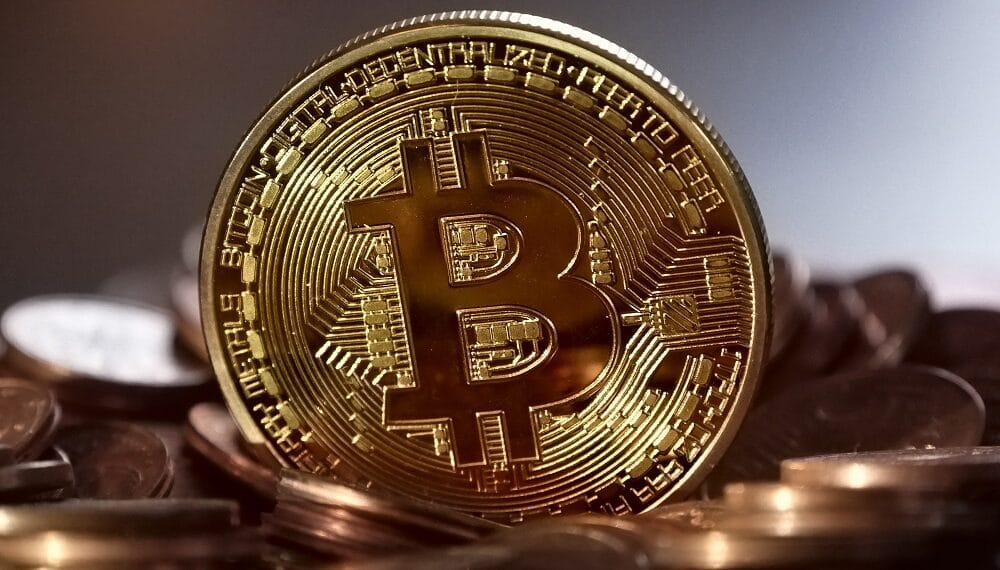

The main purpose of this notebook is to characterize the bitcoin price (https://en.wikipedia.org/wiki/Bitcoin) using an standard approach such as least squares, we will cover both ordinary least squares and nonlinear least squares, also we will answer questions such as ¿Which variables can be correlated with bitcoin? ¿ Can bitcoin price be predictable within a nonlinear model?.

First of all we will start by showing which conditions sould the data of a problem meet in order to be solvable from least squares perspective just to familiarize with the least squares conditions if the reader wish to use it in his/her ideas; second we will try to adjust some nonlinear model to predict bitcoin and try to recognize some nonlinear relation between bitcoin price and the data; third using least squares we will see if there exists some correlation between bitcoin price and some commodities price such as the gold,silver and oil prices, or in other words can we use bitcoin price to predict oil,silver or gold prices and visceversa?; and fourth we will solve the pint registration problem with Umeyama's algorithm.

This jupyter notebook is going to be written in Julia, for documentation and more information about it please visit https://julialang.org/


# Data

The data used in this notebook was taken from https://es.investing.com/ in csv format


# Importing and preprocessing data

Please make a directory called data and save in it all the csv files.

In [21]:
#Importing libraries
using CSV
using DataFrames
using Plots

In [22]:
# Importing bitcoin,gold,silver and oil data.
#-----------------------------------------------------------------------------------------------------------------
#Bitcoin data
dataBitcoin = CSV.read("data/Bitcoin.csv",DataFrame); #Creating dataframe object from csv file
dataBitcoin.Price .= replace.(dataBitcoin.Price, "," => ""); #Removing "," from the Price column
dataBitcoin.PriceFloat = parse.(Float64, dataBitcoin.Price); #Parsing price column to Float64
#------------------------------------------------------------------------------------------------------------------
#Gold data
dataGold = CSV.read("data/Gold.csv",DataFrame);
dataGold.Price .= replace.(dataGold.Price, "," => "");
dataGold.PriceFloat = parse.(Float64, dataGold.Price);
#------------------------------------------------------------------------------------------------------------------
#Oil data
dataOil = CSV.read("data/oil.csv",DataFrame)
dataOil.PriceFloat = dataOil.Price
#------------------------------------------------------------------------------------------------------------------
#Silver data
dataSilver = CSV.read("data/silver.csv",DataFrame)
dataSilver.PriceFloat = dataSilver.Price;
#-----------------------------------------------------------------------------------------------------------------
#Bitcoin data month
dataBitcoinMonth = CSV.read("data/BitcoinMes.csv",DataFrame); #Creating dataframe object from csv file
dataBitcoinMonth.Price .= replace.(dataBitcoinMonth.Price, "," => ""); #Removing "," from the Price column
dataBitcoinMonth.PriceFloat = parse.(Float64, dataBitcoinMonth.Price); #Parsing price column to Float64


Lets take a look to our bitcoin data:

In [5]:
dataBitcoin

,Date,Price,Open,High,Low,Vol.,Change %,PriceFloat
,String15,String15,String15,String15,String15,String7,String7,Float64
1,"Mar 25, 2021",51363.0,"52,347.2","52,926.0","50,874.0",11.59K,-1.88%,51363.0
2,"Mar 26, 2021",54992.9,"51,363.0","54,992.9","51,363.0",7.71K,7.07%,54992.9
3,"Mar 27, 2021",55886.0,"54,992.9","56,249.0","54,373.0",5.18K,1.62%,55886.0
4,"Mar 28, 2021",55773.0,"55,886.0","56,326.0","55,089.0",4.21K,-0.20%,55773.0
5,"Mar 29, 2021",57672.3,"55,773.0","58,162.0","54,984.0",10.12K,3.41%,57672.3
6,"Mar 30, 2021",58841.0,"57,672.3","59,349.0","57,278.0",7.87K,2.03%,58841.0
7,"Mar 31, 2021",58796.0,"58,841.0","59,453.0","57,698.0",8.12K,-0.08%,58796.0
8,"Apr 01, 2021",58727.4,"58,796.0","59,172.9","58,498.0",4.35K,-0.12%,58727.4
9,"Apr 02, 2021",58959.0,"58,727.4","59,834.0","58,727.4",6.15K,0.39%,58959.0


# 1. Conditions for a system to be solvable from least squares perspective

Least squares is a tecnique for solving overdetermined systems, which means sets of equations in which there are more equations thatn unknowns, for example:

$$y = 3x + 15$$
$$y = -5x + 1$$
$$y = 30x + 150$$

There we have 3 equations and 2 unknowns, thus this system is overdetermined, in our case consider $y$ is the bitcoin price and $x$ the day of the month.

The cases where the overdetermined systems have a solution are when the system contains enough linearly dependent equations so that the number of independent equations does not exceed the number of unknowns.

We are trying to solve

$$A^{T}Ax = A^{T}b$$

Where the combination of $Ax = b$ yield our system of equations, therefore if we wish to use least squares and this system is overdetermined (and indeed it is, becuase we have many data) we need the condtion stated above.



# 2. Nonlinear model fitting

Lets start by looking at the bitcoin price for 29 days

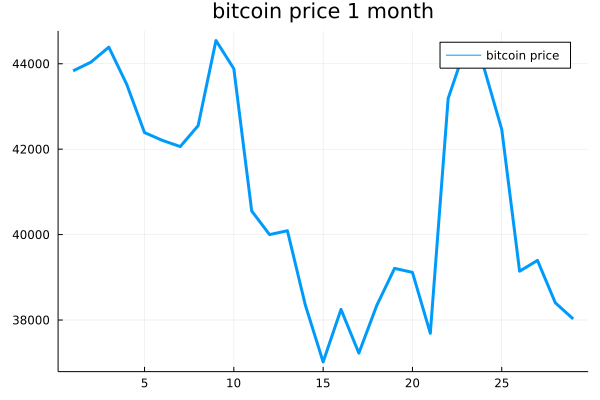

In [24]:
default(fmt = :png)
Plots.plot(dataBitcoinMonth.PriceFloat,title="bitcoin price 1 month", label="bitcoin price",lw=3)

We will try to fit the bitcoin price ($y$) to the following non-linear model using the days ($x$) as the predictors:

$$y = a +bx + cx^{2} + dx^{3} + ex^{4}(1)$$

Notice that the problem is to find $a,b,c,d,e$ that best fit the model, that means that leads to the minimal error.

First we will split the data into train and test, but before that we need to create a new column named day, that will work as our predictor.

In [24]:
N = size(dataBitcoinMonth.PriceFloat,1) # Number of days
x = Array((1:N)) # predictor variables
y = dataBitcoinMonth.PriceFloat;

Now we create a function for splitting the data into test and train, for this exercise I am going to use 90% of the data for training and 10% for testing:

We will begin by constructing our design matrixes: $A4$ will correspond to the $x^4$(1) function and $A5$ will corresponde to te $x^{5}$(2) function. 

In [33]:
A4 = [x.^0 x x.^2 x.^3 x.^4];
A5 = [x.^0 x x.^2 x.^3 x.^4 x.^5];

In [34]:
using Convex, SCS
function solvels(A,y)
    #Input -> A: Design matrix
    #      ->  y: Values to be predicted(array)
    
    #Output -> p: Best fit coefficients
        
    #Our variable to be predicted, in this case, the bitcoin price.
    b_t = y

    #Column vector variable of size n x 1.
    x_t = Variable(size(A,2))
    # The problem is to minimize ||Ax - b||^2 --> Least squares problem, so we minimize it, to obtain the coefficients
    #that better fits our model (minimal error).
    problem = minimize(square(norm(A*x_t-b_t)))
    solve!(problem, SCS.Optimizer, silent_solver = true)
    #problem.status 
    p = x_t.value
    
    return p 
end

solvels (generic function with 1 method)

Now we call the solver for finding our best fits.

In [35]:
p1 = solvels(A4,y);
p2 = solvels(A5,y);

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/alchemistdude/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/alchemistdude/.julia/packages/Convex/uI27T/src/solution.jl:263


Lets have a look to the coefficients:

In [38]:
p1

5×1 Array{Float64,2}:
 40918.35435749799
  2162.4663456868584
  -398.8359231623704
    21.96122685511365
    -0.3769421079151309

Now lets feed the models with the coefficients and the points (in our case, the days):

In [44]:
m4 = p1[1].*ones(N).+ p1[2].*x.^1 + p1[3].*x.^2 + p1[4].*x.^3 + p1[5].*x.^4
m5 = p2[1].*ones(N).+ p2[2].*x.^1 + p2[3].*x.^2 + p2[4].*x.^3 + p2[5].*x.^4 + p2[6].*x.^5;

Now lets plot the models and examine them

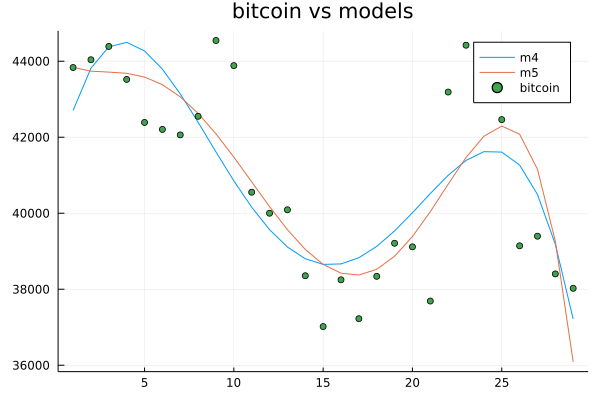

In [45]:
using Plots
default(fmt = :png)
Plots.plot(m4,title="bitcoin vs models", labels="m4")
Plots.plot!(m5,labels="m5")
Plots.scatter!(y,labels="bitcoin")

This seems to works "correctly" on predicting on data, let's test it:

In [46]:
days = [30,31,32,33,34,35]

6-element Array{Int64,1}:
 30
 31
 32
 33
 34
 35

In [1]:
m4_predict =p1[1].*ones(6).+ p1[2].*days.^1 + p1[3].*days.^2 + p1[4].*days.^3 + p1[5].*days.^4 # Function(1)
m5_predict =p2[1].*ones(6).+ p2[2].*days.^1 + p2[3].*days.^2 + p2[4].*days.^3 + p2[5].*days.^4 + p2[6].*days.^5; # Function(2)

LoadError: UndefVarError: p1 not defined

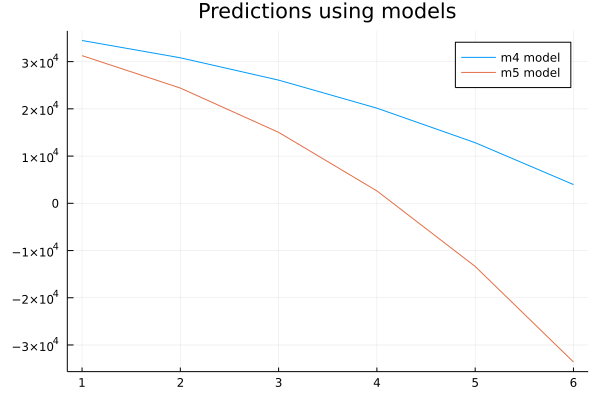

In [48]:
Plots.plot(m4_predict,title="Predictions using models",labels="m4 model")
Plots.plot!(m5_predict,labels="m5 model")

This is interesting, the model predict some negative values for the next six days on bitcoin price, this is a clear example of an overfitted model, we need to look for a simple model that gets the tendency.

# 3. Looking for a possible correlation between bitcoind and oil,silver,gold

Now we will try to see if there exists a correlation between the bitcoin price and some commodities(gold,silver,oil) using least squares, or in other words, we will try to fit a line that predicts bitcoin price tendency using as predictor variables the gold,oil and silver, by this we mean to see if the gold,oil and silver can predict the bitcoin price tendency.

In [4]:
function compact(df1,df2)
    
    #This function will take tow dataframes and make an inner join by the date
    
    #Input -> two dataframes
    #Output -> Two vectors, consisting each other of the dataframes original prices with the same dates.
    d1 = Array([])
    d2 = Array([])

    @time begin
    for i in 1:size(df1,1)
        for j in 1:size(df2,1)
            if df1.Date[i] == df2.Date[j]
                push!(d2,convert(Float64,df2.PriceFloat[j]))
                push!(d1,convert(Float64,df1.PriceFloat[i]))
            end
        end
    end
        d1 = convert(Array{Float64}, d1)
        d2 = convert(Array{Float64}, d2)
        
    end
    return d1,d2
    
    
    
end      

        

compact (generic function with 1 method)

We call the function to each commoditie along with the bitcoin data.

In [6]:
bitcoin1,gold = compact(dataBitcoin,dataGold)
bitcoin2,oil = compact(dataBitcoin,dataOil)
bitcoin3,silver = compact(dataBitcoin,dataSilver);

  0.007730 seconds (195.25 k allocations: 5.969 MiB)
  0.007908 seconds (191.58 k allocations: 5.857 MiB)
  0.010171 seconds (229.02 k allocations: 6.999 MiB)


For solving this least squares problem we will use the QR factorization approach, for more information about it please visit https://towardsdatascience.com/qr-matrix-factorization-15bae43a6b2.

Recall fom above that we are trying to solve:

$$A^T A x = A^T b$$



In [7]:
using LinearAlgebra
function solveQR(df1,df2)
    #This function will solve the least squares problem via QR descomposition.
    #Input -> two dataframes
    #Output -> least squares solution
    N = size(df1,1)
    b = df2
    A = [ones(N) df1]
    
    qrA = qr(A)
    x = qrA\b
    
    return x,A,b,N
    
end
    

solveQR (generic function with 1 method)

Now we fit the data to solve the least squares problem via QR.

In [9]:
xbg,a1,b1,n1 = solveQR(bitcoin1,gold)
xbo,a2,b2,n2 = solveQR(oil,bitcoin2)
xbs,a3,b3,n3 = solveQR(silver,bitcoin3);

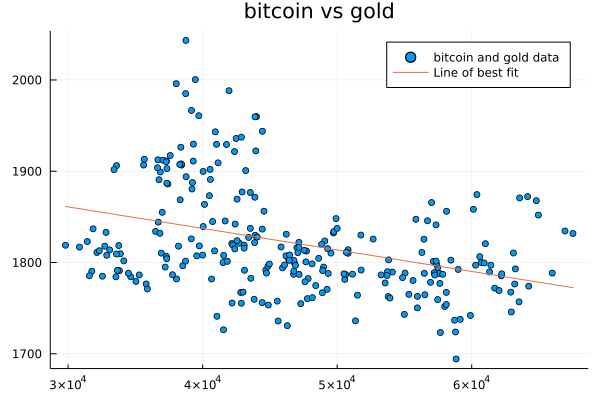

In [52]:
using Plots

#-----Bitcoin vs Gold--------------------------------------------------------------------------------------------
pred = xbg[2]*a1[:,2] + xbg[1]*ones(n1,1)
Plots.scatter(a1[:,2],b1,title="bitcoin vs gold",labels="bitcoin and gold data")
Plots.plot!(a1[:,2],pred,labels="Line of best fit")




In [12]:
using Statistics
cor(bitcoin1,gold)

-0.37094195404558766

If we make use of the Pearson correlation matrix we get a correlation value of -0.37, this can be seen in the plot as the line has a negative slope.

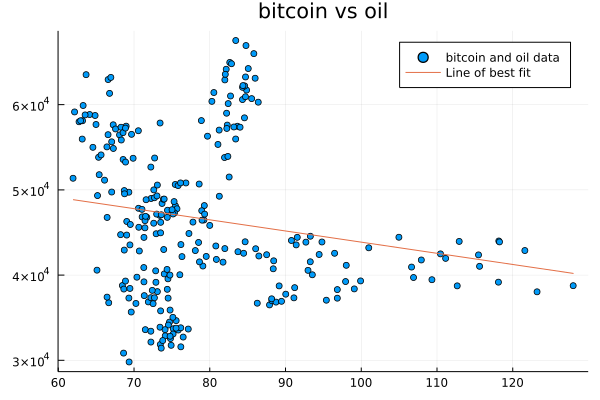

In [56]:
#-----Bitcoin vs Oil--------------------------------------------"bitcoin and oil data
pred = xbo[2]*a2[:,2] + xbo[1]*ones(n2,1)
Plots.scatter(a2[:,2],b2,title="bitcoin vs oil",labels="bitcoin and oil data")
Plots.plot!(a2[:,2],pred,labels="Line of best fit")

In [13]:
using Statistics
cor(bitcoin2,oil)

-0.17965177109775182

If we make use of the Pearson correlation matrix we get a correlation value of -0.18, this can be seen in the plot as the line has a negative slope.

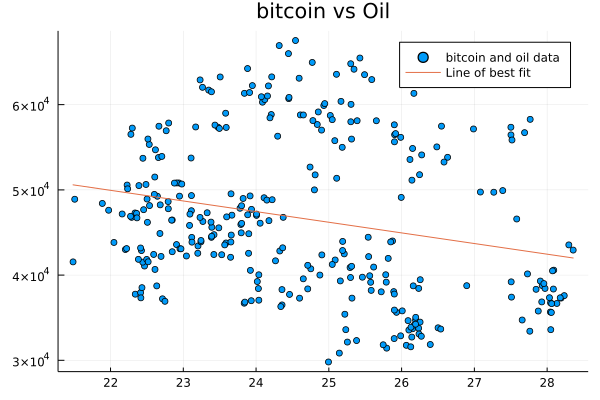

In [57]:
#-----Bitcoin vs Silver-----------------------------------------------------------------------------------------
pred = xbs[2]*a3[:,2] + xbs[1]*ones(n3,1)
Plots.scatter(a3[:,2],b3,title="bitcoin vs Oil",labels="bitcoin and oil data")
Plots.plot!(a3[:,2],pred,labels="Line of best fit")

In [14]:
using Statistics
cor(bitcoin3,silver)

-0.23446302591671822

If we make use of the Pearson correlation matrix we get a correlation value of -0.23, this can be seen in the plot as the line has a negative slope.

In conclusion bitcoin has a small negative correlation with gold,oil and silver, so we can expect small changes when for example gold increases the bitcoin decreases in a small proportion.

# 4. Registration problem

The registration problem consists of aligning two set points or two point clouds.The purpose of finding such a transformation includes merging multiple data sets into a globally consistent model (or coordinate frame), and mapping a new measurement to a known data set to identify features or to estimate its pose.

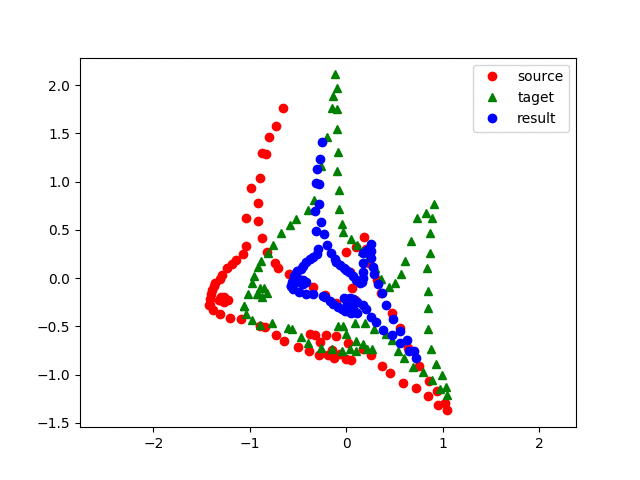

In [1]:
function castp(ar)
    #Takes an array of Point2f pair of numbers and cast it to two arrays of float64.
    x = Array([])
    y = Array([])
    N = size(ar,1)
    
    for i in 1:N
        push!(x,convert(Float64,ar[i][1]))
        push!(y,convert(Float64,ar[i][2]))
        
    end
    x = convert(Array{Float64}, x)
    y = convert(Array{Float64}, y)
    return x,y,N
end




castp (generic function with 1 method)

In [11]:
function transformation(x,y)
    # Takes two numbers and transform them randomly.
    t = rand(1)
    x2 = x.* t
    y2 = y.* t
    
    return x2,y2
end
    

transformation (generic function with 1 method)

In [12]:
using LinearAlgebra
using Statistics
function umeyama(A,B)
    #Solves the registration problem by Umeyama algorithm.
    n,m = size(A)
    
    EA = mean(A,dims=1)
    EB = mean(B,dims=1)
    VarA = mean((norm.(A.-EA,2).^2)[:,2])
    
    H = (transpose((A.-EA)) * (B.-EB))/n
    U,D,VT=svd(H)
    d = sign(det(U)*det(VT))
    S = diagm(0 => ([1*(m-1), d]))
    R = U * S * VT
    c = VarA/tr(diagm(0 => (D))*S)
    t=EA.-EB*(c*R)
    
    return R,c,t
end
    

umeyama (generic function with 1 method)

The GUI consists of two plots and one button: The left plot is for drawing, please use a+left click to draw points, when you have finished please press the button "solve", at the right plot the red points where the ones you drawed, the green points are the transformation of the original points, and the orange points are the solution of the problem that is moving the green points to the red points.


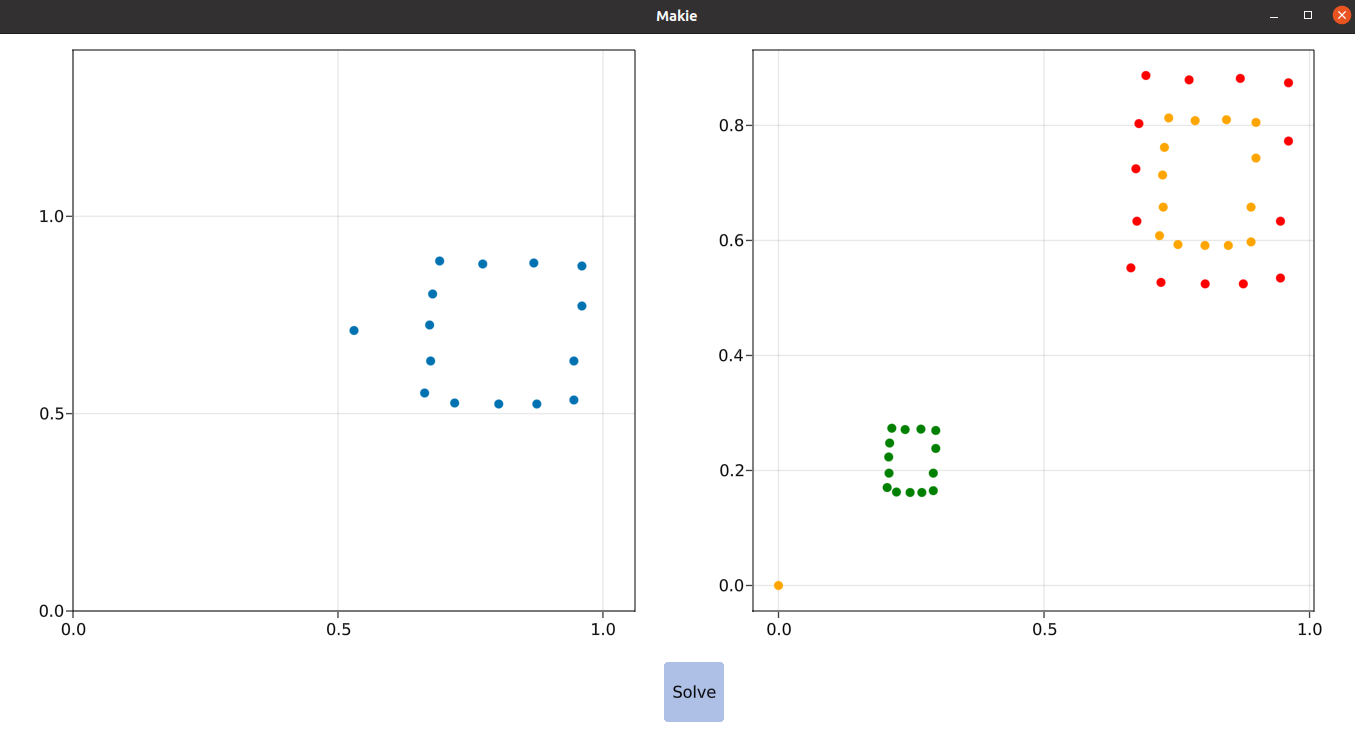

In [31]:
using Makie
using GLMakie
# initialize plot
fig = Figure(resolution = (3840, 2160))

# add axis


ax1 = fig[1:9,1] = Axis(fig,
    # 
    aspect = 1, targetlimits = BBox(-10, 10, -10, 10)
    
)



ax2 = fig[1:9,2] = Axis(fig,
    aspect = 1, targetlimits = BBox(-10, 10, -10,10)
)



#button

b = Button(fig[10,1:2],height = 60,width=60,label="Solve")

#Drawing on ax1
positions1 = Observable(rand(Point2f, 1))

draw = Array([])

scat1 = Makie.scatter!(ax1,positions1)
on(events(fig).mousebutton, priority = 0) do event
    if event.button == Mouse.left
        if event.action == Mouse.press
            if Keyboard.a in events(fig).keyboardstate
                push!(positions1[], mouseposition(ax1.scene))
                push!(draw,mouseposition(ax1.scene))
                notify(positions1)
                return Consume(true)
            end 
        end
    end
    

    return Consume(false)
end




on(b.clicks) do _
    
    positions2 = Observable([(0.0,0.0)])
    positions3 = Observable([(0.0,0.0)])
    x1,y1,N = castp(draw)
    x2,y2 = transformation(x1,y1)
    
    for i in 1:N
        push!(positions2[], (x1[i],y1[i]))
        push!(positions3[],(x2[i],y2[i]))
    end
        
    popfirst!(positions2[])
    popfirst!(positions3[])
    

        
    scat2 = Makie.scatter!(ax2,positions2,color="red")
    scat3 = Makie.scatter!(ax2,positions3,color="green")
    
    A = [x1 y1]
    B = [x2 y2]
    
    R,c,t=umeyama(A,B)
    
    bx=Array([])
    by=Array([])

    for i in 1:size(B,1)
        aux = t.+c*R*B[i,:]
        xi = aux[1,1]
        yi = aux[2,2]
        push!(bx,xi)
        push!(by,yi)
    end

    bx = convert(Array{Float64}, bx)
    by = convert(Array{Float64}, by)
    
    positions4 = Observable([(0.0,0.0)])
    
    for i in 1:N
        push!(positions4[], (bx[i],by[i]))
    end
    
    scat4 = scatter!(ax2,positions4,color="orange")
    
    
 
    
    


end
    



display(fig)

GLMakie.Screen(...)